### Importing Libraries

The code begins by importing essential libraries for data analysis, mapping, and visualization:

- **`pandas`**: For data manipulation.
- **`numpy`**: For mathematical operations.
- **`matplotlib`** & **`seaborn`**: For data visualization.
- **`folium`**: For creating interactive maps.
- **`plotly.express`**: For interactive plotting.
- **`osmnx & networkx`**: For network analysis and mapping.
- **`ortools`**: For solving mathematical optimization problems.


In [1]:
import pandas as pd
import numpy as np
import folium
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt


### Data Preparation for Plotting Points on Cairo Map

The code prepares data for plotting points on a map of Cairo.

#### Key Details:
- **Number of Points**: 18.
- **Starting Point**:
  - Coordinates: (30.13, 31.35).
  - Color: green.
- **Other Points**: Color: blue.


In [2]:
data = pd.read_csv('Cairo_data.csv')

data = data.drop(columns=["id"], errors='ignore')

data = data.reset_index().rename(columns={"index": "id", "Latitude": "y", "Longitude": "x"})

print("total", len(data))
print(data.head(3))


total 17
   id   City                                     Street Address      y      x
0   0  Cairo                 6 Of Octobe, El Horya Square, Giza  30.13  31.35
1   1  Cairo  Zaker Hussein St. extension, Plot no. 4, Unit ...  30.05  31.25
2   2  Cairo  Unit no :A1 Front of British School, 6 of oct/...  30.01  31.27


In [3]:
data["color"] = ''  # إضافة عمود جديد للون
data.loc[data['id'] == 0, 'color'] = 'green'  # تحديد النقطة الابتدائية باللون الأخضر
data.loc[data['id'] != 0, 'color'] = 'blue'   # باقي النقاط باللون الأزرق

start = data[data["id"] == 0][["y", "x"]].values[0]
print("starting point:", start)


starting point: [30.13 31.35]


### Traffic Network Creation Using OSMnx

The code creates a traffic network based on the starting point using the **OSMnx** library.

#### Key Function: `ox.graph_from_point`

- **Purpose**: Generates a geographic graph of roads around the starting point.  
- **Parameters**:  
  - `start`: Starting point coordinates.  
  - `dist=25000`: Defines a 25 km radius around the starting point.  
  - `network_type="drive"`: Specifies that the network includes only drivable roads.

#### Key Steps:

1. **Generate a Traffic Network**:  
   - Build a road network around the starting point.  
   - Link the original points to network nodes.  

2. **Calculate Closest Nodes**:  
   - Identify the nearest node for each point.  

3. **Create a Distance Matrix**:  
   - Compute distances between every pair of points.

#### Final Output:

A distance matrix that can be used to optimize routes and select the most suitable paths.


In [4]:
map = folium.Map(location=start, tiles="cartodbpositron", zoom_start=12)

data.apply(lambda row: 
    folium.CircleMarker(
        location=[row["y"], row["x"]], 
        color=row["color"], fill=True, radius=7).add_to(map), axis=1)

map

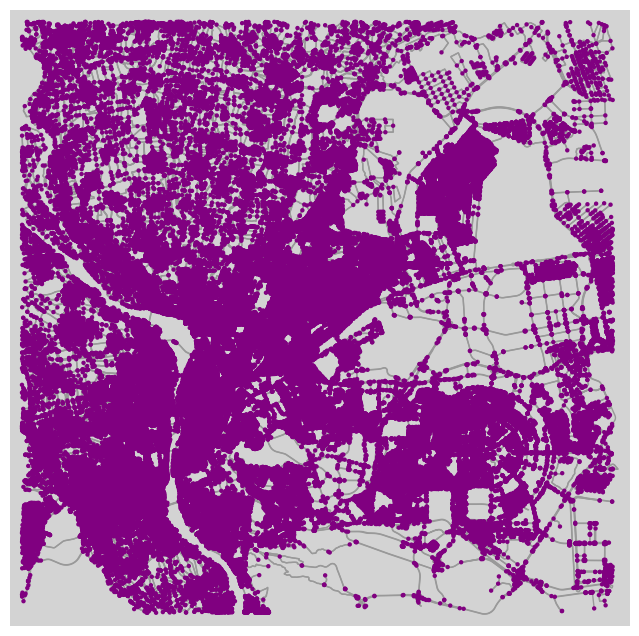

C:\Users\HELAL\AppData\Local\Temp\ipykernel_2396\2244057955.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data["node"] = data[["y", "x"]].apply(lambda x: ox.distance.nearest_nodes(G, x[1], x[0]), axis=1)
C:\Users\HELAL\AppData\Local\Temp\ipykernel_2396\2244057955.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data["node"] = data[["y", "x"]].apply(lambda x: ox.distance.nearest_nodes(G, x[1], x[0]), axis=1)
C:\Users\HELAL\AppData\Local\Temp\ipykernel_2396\2244057955.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

,id,City,Street Address,y,x,color,node
0,0,Cairo,"6 Of Octobe, El Horya Square, Giza",30.13,31.35,green,6474929279
1,1,Cairo,"Zaker Hussein St. extension, Plot no. 4, Unit ...",30.05,31.25,blue,316705454
2,2,Cairo,"Unit no :A1 Front of British School, 6 of oct/...",30.01,31.27,blue,8431379423
4,4,Cairo,"City stars Mall, Nasr city",30.02,31.20,blue,6436112211
5,5,Cairo,"Plot no: 35 south investors zone, off 90 road,...",30.04,31.24,blue,6655391400


In [5]:
# dist=25000 هنا تقدر تقلل المسافة او تزودها حسب تجمع النقاط بتفرق ف التحليات الجاية 
G = ox.graph_from_point(start, dist=25000, network_type="drive")
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

fig, ax = ox.plot_graph(G, bgcolor="lightgray", node_size=10, node_color="purple", figsize=(12, 8))

start_node = ox.distance.nearest_nodes(G, start[1], start[0])

data["node"] = data[["y", "x"]].apply(lambda x: ox.distance.nearest_nodes(G, x[1], x[0]), axis=1)
data = data.drop_duplicates("node", keep='first')

data.head()


In [6]:
from ortools.constraint_solver import pywrapcp 
from ortools.constraint_solver import routing_enums_pb2

def f(a, b):
    try:
        d = nx.shortest_path_length(G, source=a, target=b, method='dijkstra', weight='travel_time')
    except:
        d = np.nan
    return d

distance_matrix = np.asarray([[f(a, b) for b in data["node"].tolist()] for a in data["node"].tolist()])
distance_matrix = pd.DataFrame(distance_matrix, columns=data["node"].values, index=data["node"].values)

distance_matrix.head()

drivers = 1
nodes = data["node"].tolist()
start_node_idx = nodes.index(start_node)

manager = pywrapcp.RoutingIndexManager(len(nodes), drivers, start_node_idx)
model = pywrapcp.RoutingModel(manager)

def get_distance(from_index, to_index):
    return distance_matrix.iloc[from_index, to_index]

distance = model.RegisterTransitCallback(get_distance)
model.SetArcCostEvaluatorOfAllVehicles(distance)

parameters = pywrapcp.DefaultRoutingSearchParameters()
parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC

solution = model.SolveWithParameters(parameters)


In [7]:
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2

def f(a, b):
    try:
        d = nx.shortest_path_length(G, source=a, target=b, method='dijkstra', weight='travel_time')
    except:
        d = np.nan
    return d

distance_matrix = np.asarray([[f(a, b) for b in data["node"].tolist()] for a in data["node"].tolist()])
distance_matrix = pd.DataFrame(distance_matrix, columns=data["node"].values, index=data["node"].values)


distance_matrix = distance_matrix.round()
distance_matrix = distance_matrix.astype('int')
distance_matrix

drivers = 1
nodes = data["node"].tolist()
start_node_idx = nodes.index(start_node)

manager = pywrapcp.RoutingIndexManager(len(nodes), drivers, start_node_idx)
model = pywrapcp.RoutingModel(manager)

def get_distance(from_index, to_index):
    return distance_matrix.iloc[from_index, to_index]

distance = model.RegisterTransitCallback(get_distance)
model.SetArcCostEvaluatorOfAllVehicles(distance)

parameters = pywrapcp.DefaultRoutingSearchParameters()
parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC

solution = model.SolveWithParameters(parameters)


In [8]:
drivers = 1
nodes = data["node"].tolist()
start_node_idx = nodes.index(start_node)

manager = pywrapcp.RoutingIndexManager(len(nodes), drivers, start_node_idx)
model = pywrapcp.RoutingModel(manager)

def get_distance(from_index, to_index):
    return distance_matrix.iloc[from_index, to_index]

distance = model.RegisterTransitCallback(get_distance)
model.SetArcCostEvaluatorOfAllVehicles(distance)

parameters = pywrapcp.DefaultRoutingSearchParameters()
parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC

solution = model.SolveWithParameters(parameters)


In [9]:
index = model.Start(0)
print('route for driver:')

route_idx, route_distance = [], 0
while not model.IsEnd(index):
    route_idx.append(manager.IndexToNode(index))
    previous_index = index
    index = solution.Value(model.NextVar(index))

    try:
        route_distance += get_distance(previous_index, index)
    except:
        route_distance += model.GetArcCostForVehicle(from_index=previous_index, to_index=index, vehicle=0)

print(route_idx)
print(f'Total distance: {round(route_distance / 1000, 2)} km')
print(f'Nodes visited: {len(route_idx)}')


route for driver:
[0, 4, 1, 9, 8, 3, 2, 6, 5, 7]
Total distance: 3.32 km
Nodes visited: 10


In [10]:
print("Route for driver (nodes):")
route_nodes = [nodes[i] for i in route_idx]
print(route_nodes)

def get_path_between_nodes(route_nodes):
    paths = []
    for i in range(len(route_nodes) - 1):
        try:
            a, b = route_nodes[i], route_nodes[i + 1]
            path = nx.shortest_path(G, source=a, target=b, method='dijkstra', weight='travel_time')
            if len(path) > 1:
                paths.append(path)
        except Exception as e:
            print(f"Error between nodes {a} and {b}: {e}")
            continue
    return paths

paths = get_path_between_nodes(route_nodes)

# رسم المسارات
for path in paths:
    coords = [(G.nodes[node]['y'], G.nodes[node]['x']) for node in path]
    folium.PolyLine(coords, color="orange", weight=3, opacity=1).add_to(map)

map


Route for driver (nodes):
[6474929279, 6655391400, 316705454, 6262096698, 6797039411, 6436112211, 8431379423, 6465150971, 10841836462, 9983033982]
